영어(코드)에 대한 설명은 바로 아래의 한글설명을 참고하시면 됩니다.

# 0. 라이브러리 불러오기

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

### 사용한 라이브러리는 matplotlib, numpy, pandas, seaborn, pmdarima 5개입니다.

# 1. 데이터 불러오기


In [ ]:
df0 = pd.read_excel('/content/양주시인구데이터_0130.xlsx')
print(df0.shape)
display(df0.head(5))
display(df0.tail(5))

(102, 2)


,시간,총인구수
0,2015-06-01,210914
1,2015-07-01,211284
2,2015-08-01,211402
3,2015-09-01,211605
4,2015-10-01,211839


,시간,총인구수
97,2023-07-01,268951
98,2023-08-01,270758
99,2023-09-01,272084
100,2023-10-01,273666
101,2023-11-01,275060


### 데이터는 양주시 인구데이터를 2015년 6월부터 2023년 11월까지를 추출한 것입니다.

In [ ]:
stock_a = df0.loc[:, ['시간', '총인구수']]
# 인덱스 설정 후 drop
stock_a.index = stock_a.시간
stock_a = stock_a.drop(columns="시간")
stock_a

,총인구수
시간,
2015-06-01,210914
2015-07-01,211284
2015-08-01,211402
2015-09-01,211605
2015-10-01,211839
...,...
2023-07-01,268951
2023-08-01,270758
2023-09-01,272084


### 분석하기 편리하게 인덱스를 시간으로 설정하였습니다. 이렇게 바꾸지 않으면 시각화 할 때 x축에 1, 2, 3, 이런식으로 나옵니다.

In [ ]:
train = stock_a['총인구수'][:int(0.8*len(stock_a))]
test = stock_a['총인구수'][int(0.8*len(stock_a)):]

### 앞의 80% 데이터는 train 데이터로, 뒤의 20% 데이터는 test 데이터로 나누기
### 시계열 데이터는 시간 변수에 따른 자기상관성이 있기 때문에 함부로 shuffle을 통한 분리를 실시할 수 없는 것이 특징입니다.

### 여기서 자기상관이란, 시계열 데이터에서 연속된 관측치 사이의 상관관계를 의미합니다. 이는 시간의 흐름에 따른 데이터의 패턴을 분석할 때 주로 발생하는 문제입니다. (잔차의 독립성 가정 위배, 검정 통계량이 잘못 계산됨, 모형의 예측력이 떨어지는 문제)

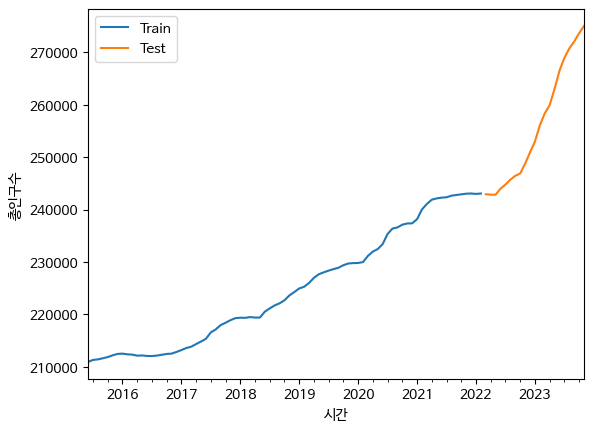

In [ ]:
train.plot(label='Train')
test.plot(label='Test')

plt.xlabel('시간')
plt.ylabel('총인구수')

plt.legend()
plt.show()

### 시각화로 확인

### 시간이 지남에 따라 증가하는 추세가 있는 것으로 보이므로 차분을 통해 정상성 데이터로 만들어주어야 할 듯 합니다.

- 차분 : 연속적으로 측정된 관측치 간의 차이를 계산하는 것.

- 정상성데이터 : 시간이 지남에 따라서 시계열의 확률적 특징들이 변하지 않는 데이터. 시계열 모형은 이전 데이터를 바탕으로 만들어지고 예측을 합니다. 시간이 지남에 따라 데이터의 특징이 바뀌면 예측이 불가능하기 때문에 차분을 통해 데이터의 특징을 일정하게 만듭니다.

In [ ]:
pip install pmdarima


In [ ]:
import pmdarima as pm

kpss_diffs = pm.arima.ndiffs(train, alpha=0.05, test='kpss', max_d=5)
adf_diffs = pm.arima.ndiffs(train, alpha=0.05, test='adf', max_d=5)
n_diffs = max(kpss_diffs, adf_diffs)

print(f"Optimized 'd' = {n_diffs}")

Optimized 'd' = 2


### 정상성을 달성하기 위해 필요한 차분의 횟수는 2회

In [ ]:
model2 = pm.auto_arima(train, d=2, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1173.925, Time=0.79 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1166.552, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1168.322, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1168.316, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1164.559, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1169.606, Time=0.23 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 1.177 seconds


### 함수를 사용하여 자동으로 ARIMA 모델을 생성하고 최적의 모델을 찾는 과정을 수행합니다.
### 여기서는 train 데이터를 사용하고, d=2로 두 번 차분된 시계열 데이터를 입력으로 넣었습니다.

 ### AIC 값이 가장 낮은 모형이 좋은 모형인 경향이 있으므로 ARIMA(0,2,0) 모델 채택

In [ ]:
model2.summary()

In [ ]:
model2.plot_diagnostics(figsize=(16,8))
plt.show()

In [ ]:
test.shape

(21,)

### 한 지점에 대한 예측을 진행하고 모델을 업데이트 하는 방식으로 예측을 진행 (트렌드 이외에도 변동요인들이 모두 반영 : 추세변동, 계절변동, 순환변동, 불규칙변동)

In [ ]:
# one point forcast 함수 정의, 신뢰구간도 함께 담아보기
def forcast_one_step():
    fc, conf = model2.predict(n_periods=1, return_conf_int=True)
    return fc.tolist()[0], np.asarray(conf).tolist()[0]

# 값들을 담을 빈 리스트를 생성
y_pred = []
pred_upper = []
pred_lower = []

# for문을 통한 예측 및 모델 업데이트를 반복함
for new_ob in test:
    fc, conf = forcast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])
    model2.update(new_ob)

In [ ]:
test_pred2 = pd.DataFrame({'test':test, 'pred':y_pred})
y_pred_df = test_pred2['pred']	# Series로 반환
y_pred_df

시간
2022-03-01    243139.0
2022-04-01    242774.0
2022-05-01    242779.0
2022-06-01    242831.0
2022-07-01    245150.0
2022-08-01    245559.0
2022-09-01    246623.0
2022-10-01    247192.0
2022-11-01    247334.0
2022-12-01    250602.0
2023-01-01    253094.0
2023-02-01    255028.0
2023-03-01    259170.0
2023-04-01    260648.0
2023-05-01    261496.0
2023-06-01    266164.0
2023-07-01    269944.0
2023-08-01    271407.0
2023-09-01    272565.0
2023-10-01    273410.0
2023-11-01    275248.0
Name: pred, dtype: float64

### 예측 결과를 데이터프레임으로 만들었습니다

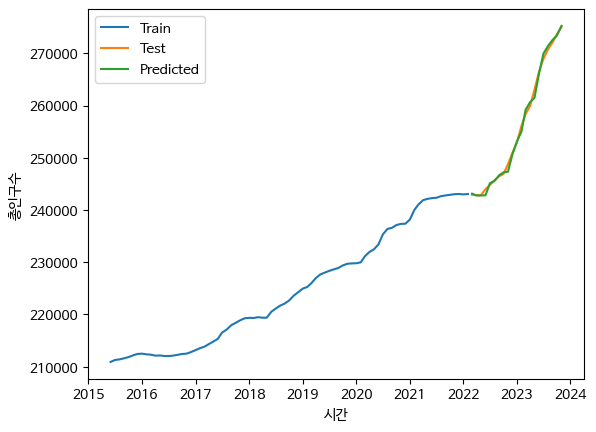

In [ ]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_pred_df, label='Predicted')
plt.legend()
plt.xlabel('시간')
plt.ylabel('총인구수')
plt.show()

### 차분을 2번 하여 만든 ARIMA 모델을 이용한 데이터 예측결과는 초록색(predicted) 결과이며, 원본데이터는 노란색(Test) 데이터입니다. 초록색이 원본데이터와 유사하게 그려진 것으로 보아 잘 학습된 것을 알 수 있습니다.

In [ ]:
model2.summary()

In [ ]:
# 예측 결과를 저장할 빈 리스트 생성
y_pred = []
pred_upper = []
pred_lower = []

# for문을 통한 예측 및 모델 업데이트 반복
for new_ob in test:
    fc, conf = forcast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])
    model2.update(new_ob)

# 2026년 12월까지의 예측을 포함하여 데이터프레임 생성
예측_월수 = 36  # 원하는 미래 기간에 따라 조절
for _ in range(예측_월수):
    fc, conf = forcast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])
    model2.update(fc)

# 예측 결과를 담은 데이터프레임 생성
test_pred2 = pd.DataFrame({'test': test, 'pred': y_pred[:len(test)]})
y_pred_df = pd.Series(y_pred[len(test):], name='pred', index=pd.date_range(start='2023-12-01', periods=예측_월수, freq='M'))

# 데이터프레임 출력
y_pred_df

2023-12-31    276454.0
2024-01-31    277848.0
2024-02-29    279242.0
2024-03-31    280636.0
2024-04-30    282030.0
2024-05-31    283424.0
2024-06-30    284818.0
2024-07-31    286212.0
2024-08-31    287606.0
2024-09-30    289000.0
2024-10-31    290394.0
2024-11-30    291788.0
2024-12-31    293182.0
2025-01-31    294576.0
2025-02-28    295970.0
2025-03-31    297364.0
2025-04-30    298758.0
2025-05-31    300152.0
2025-06-30    301546.0
2025-07-31    302940.0
2025-08-31    304334.0
2025-09-30    305728.0
2025-10-31    307122.0
2025-11-30    308516.0
2025-12-31    309910.0
2026-01-31    311304.0
2026-02-28    312698.0
2026-03-31    314092.0
2026-04-30    315486.0
2026-05-31    316880.0
2026-06-30    318274.0
2026-07-31    319668.0
2026-08-31    321062.0
2026-09-30    322456.0
2026-10-31    323850.0
2026-11-30    325244.0
Freq: M, Name: pred, dtype: float64

### 위 모델을 바탕으로 새로운 날짜의 인구수를 예측해보았습니다.

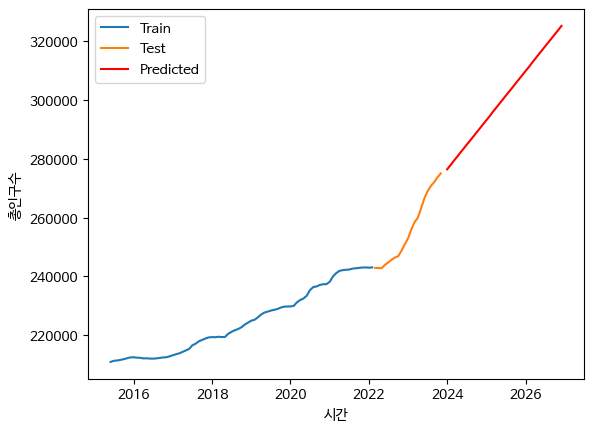

In [ ]:
# 훈련 데이터, 테스트 데이터, 예측값을 플로팅
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_pred_df, label='Predicted', color='red')  # 예측값을 빨간색으로 설정
plt.legend()
plt.xlabel('시간')
plt.ylabel('총인구수')
plt.show()

###ARIMA 모형을 이용한 예측 결과 시간이 지남에 따라 양주시 인구수가 증가하는 것으로 파악됩니다.

참고 ) https://velog.io/@dankj1991/time-series-3-ARIMA
